<a href="https://colab.research.google.com/github/KorostinD/Diploma_project/blob/main/Denoising_Autoencoder_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
def max_arg(arr):
  shape=arr.shape
  max1=0
  for i in range(shape[0]):
    for j in range(shape[1]):
      if arr[i,j]>max1:
        max1=arr[i,j] 
  return max1


In [9]:
import numpy as np
import librosa as lb
import librosa.display
import torch
from torch import nn
import torchvision.transforms as tfs
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os


input_data=np.zeros((350,1025,87))
label_data=np.zeros((350,1025,87))
test_input_data=np.zeros((50,1025,87))
test_label_data=np.zeros((50,1025,87))
for i in range(400):
  sample,sr=lb.load(f'/content/drive/MyDrive/audiosample_dataset/noisy_samples/{i}.wav',sr=44100)
  label,sr=lb.load(f'/content/drive/MyDrive/audiosample_dataset/clean_samples/{i}.wav',sr=44100)
  fourier_noisy= librosa.stft(sample) 
  fourierdb_noisy = librosa.amplitude_to_db(abs(fourier_noisy))
  fourierdb_noisy_max=max_arg(fourierdb_noisy)
  fourierdb_noisy=fourierdb_noisy/fourierdb_noisy_max
  fourier= librosa.stft(label) 
  fourierdb = librosa.amplitude_to_db(abs(fourier))
  fourierdb_max=max_arg(fourierdb)
  fourierdb=fourierdb/fourierdb_max

  

  if i >349:
    test_input_data[i-350]=fourierdb_noisy
    test_label_data[i-350]=fourierdb
  else:
    input_data[i]=fourierdb_noisy
    label_data[i]=fourierdb


input_data=torch.tensor(input_data,dtype=torch.float64)
label_data=torch.tensor(label_data,dtype=torch.float64)
test_input_data=torch.tensor(test_input_data,dtype=torch.float64)
test_label_data=torch.tensor(test_label_data,dtype=torch.float64)
# print(fourierdb_noisy)
# print(fourierdb)
# print(label_data)

In [10]:
class SpecDataset(Dataset):
    def __init__(self, input_data, label_data, transform=False):
        self.noisy_data = input_data
        self.clean_data = label_data
        
    def __len__(self):
        data_len=(self.noisy_data.shape)[0]
        return data_len

    def __getitem__(self, idx):
        noisy_sample=self.noisy_data[idx]
        label_sample=self.clean_data[idx]

        return noisy_sample, label_sample

epoch [1/100], loss:0.06460545
epoch [2/100], loss:0.05651458
epoch [3/100], loss:0.05381035
epoch [4/100], loss:0.04193297
epoch [5/100], loss:0.08432474
epoch [6/100], loss:0.05210627
epoch [7/100], loss:0.05447862
epoch [8/100], loss:0.03688003
epoch [9/100], loss:0.08796408
epoch [10/100], loss:0.02171239
epoch [11/100], loss:0.07792969
epoch [12/100], loss:0.28022993
epoch [13/100], loss:0.15590253
epoch [14/100], loss:0.08101008
epoch [15/100], loss:0.15698489
epoch [16/100], loss:0.06388942
epoch [17/100], loss:0.07559049
epoch [18/100], loss:0.14925938
epoch [19/100], loss:0.12426968
epoch [20/100], loss:0.02915160
epoch [21/100], loss:0.04160633
epoch [22/100], loss:0.15275490
epoch [23/100], loss:0.01945277
epoch [24/100], loss:0.15411123
epoch [25/100], loss:0.12107323
epoch [26/100], loss:0.13021812
epoch [27/100], loss:0.23124292
epoch [28/100], loss:0.23341060
epoch [29/100], loss:0.08724361
epoch [30/100], loss:0.05210627
epoch [31/100], loss:0.18171318
epoch [32/100], l

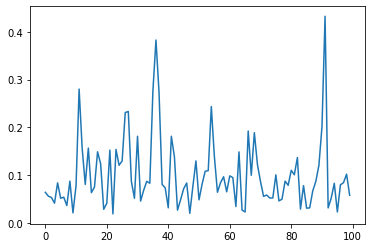

In [13]:
import matplotlib.pyplot as plt

Dataset=SpecDataset(input_data,label_data)
train_loader=DataLoader(Dataset,batch_size=1,shuffle=True,drop_last=False)
test_loader=DataLoader(Dataset,batch_size=1,shuffle=False)

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, (3,3), stride=3, padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            nn.Conv2d(8, 32, (3,3), stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1) 

            
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, (3,3), stride=2), 
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, (5,5), stride=3, padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, (3,3), stride=2, padding=1),
            nn.Tanh(),
            nn.ReLU(True)
        )

    def forward(self, x):
        x=x.to(torch.float32)
        x = self.encoder(x)
        x = self.decoder(x)
        #x=x.to(torch.float64)
        return x

model=autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5,
                             weight_decay=0)

num_epochs=100
losslist=list()
for epoch in range(num_epochs):
    for noisy_sample, label_sample in train_loader:
      output=model(noisy_sample)
      loss=criterion(noisy_sample,label_sample)
      optimizer.zero_grad()
      loss.requires_grad=True
      loss.backward()
      optimizer.step()
      # loss_np=loss.detach().numpy()
      # losslist.append(loss_np)
    print('epoch [{}/{}], loss:{:.8f}'
            .format(epoch+1, num_epochs, loss))
    loss_np=loss.detach().numpy()
    losslist.append(loss_np)
#looslist=losslist.detach().numpy()
plt.plot(range(len(losslist)),losslist)

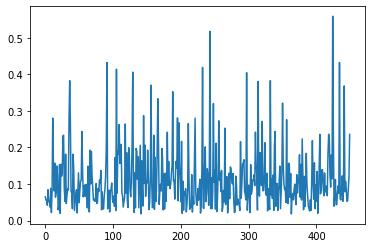

In [14]:
test_losslist=list()
for noisy_sample, label_sample in train_loader:
      output=model(noisy_sample)
      loss=criterion(noisy_sample,label_sample)
      loss_np=loss.detach().numpy()
      losslist.append(loss_np)
#looslist=losslist.detach().numpy()
plt.plot(range(len(losslist)),losslist)